In [2]:
import eniric
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from eniric.atmosphere import Atmosphere
from eniric.Qcalculator import rv_precision
from eniric.Qcalculator import quality
import colorful as cl
from scipy.signal import find_peaks
%matplotlib notebook

In [3]:
# Read FITS file
espresso = True
carmenes = False
if espresso:
    # Read the ESPRESSO file
    hdu = fits.open('/home/solene/ESPRESSO_data/molecfit_corr/output/HD41248_1_22_S1D_A_TAC.fits')
    data_tell = hdu[1].data
    wave = data_tell['wavelength'] *0.0001  #(microns)
    flux_in = data_tell['flux']
    flux_corr = data_tell['tacflux']
    trans = data_tell['mtrans']
    # G = 464 nm
    # R = 658 nm 
    # I = 806 nm
    # Z = 900 nm
elif carmenes:
    # Read the carmenes file
    hdu = fits.open('car-20160325T05h28m38s-sci-gtoc-nir_A_input_TAC.fits')
    data_tell = hdu[1].data
    wave = data_tell['WAVE'] *0.0001  #(microns)
    flux_in = data_tell['SPEC']
    flux_corr = data_tell['tacflux']
    trans = data_tell['mtrans']
else:
    print('Read your own spectrum')

In [4]:
# Define order limits
if espresso:
    # Create a mask with False, the artefacts will be marked as True
    mask_artefact = np.zeros_like(wave, dtype=bool)
    # Define order limits
    order_limits = wave[::1000]
    order_limits = np.append(order_limits, wave[-1])

elif carmenes:
    # Mask artefact
    ind = find_peaks(-flux_in, threshold=0.15)[0]
    # Missing one artefact
    ind_1 = np.sort(np.append(ind, 63780))
    # Create a mask where the artefacts are marked as True
    mask_artefact = np.zeros_like(wave, dtype=bool)
    mask_artefact[ind_1] = True
    # Define order limits
    limits = [[ww, ww1] for ww, ww1 in zip(wave, wave[1:]) if (ww1-ww) > 0.0002]
    # Flattening the list
    flat_limits = [item for sublist in limits for item in sublist]
    # Adding the first and the last wavelengths
    order_limits = [wave[0]] + flat_limits
    order_limits.append(wave[-1])
else:
    pass

In [6]:
# Identifying badly corrected telluric lines
# Rough estimate
# 
# Idea improvement:
# should replace the median line by a first order polinomial to fit the continumm 
# and measure the points which are too much above and below this continuum
# 
def select_bad_tell_corr(wave, flux_in, trans, flux_corr, wl_min, wl_max, mask_artefact, plot=True):
    # Select the wavelengths of one order, without the artefacts
    one_order = (wave >= wl_min) & (wave <= wl_max) & ~mask_artefact
    # Compute the residuals on this order
    res = flux_in[one_order] - trans[one_order]
    # Median and limits on the residuals
    med_res = np.median(res)
    max_res = med_res + np.std(res)
    min_res = med_res - np.std(res)
    if plot:
        pass
        # print('Residuals\nmean,  + std,  - std: ')
        # print(med_res, max_res, min_res)
    
    # Deep telluric lines definition: transmission below 90%
    deep_tell = trans[one_order] < 0.9
    # Wavelength and residuals of the deep tellurics
    wave_deep = wave[one_order][deep_tell]
    res_deep = res[deep_tell]

    # Checking for the level of the telluric correction
    # If more than two red points are over the max_res (or min_res limits NO) 
    # then the wavelengths are saved in a list: wl_bad
    wl_bad = []
    for ww0, ww1, ww2, rr0, rr1, rr2 in zip(wave_deep, wave_deep[1:], wave_deep[2:], res_deep, res_deep[1:], res_deep[2:]):
        if rr0 > max_res and rr1 > max_res and rr2 > max_res:
            wl_bad.append(ww0)
            wl_bad.append(ww1)
            wl_bad.append(ww2)
        elif rr0 < min_res and rr1 < min_res and rr2 < min_res:
            pass
            # plt.plot(ww0, -0.6, 'k.') plt.plot(ww1, -0.62, 'r.') plt.plot(ww2, -0.64, 'b.')
        else:
            pass
    
    # Removing duplicates by transforming list in set
    wl_badly_corrected = list(set(wl_bad))
    # Ordering the list
    wl_badly_corrected.sort()

    # Find indexes of wl_badly_corrected in the full wavelengths
    idx_bad_values_wave_one_order = np.isin(wave[one_order], wl_badly_corrected)
    if plot:
        pass
        # print('Number of pixels with badly corrected telluric lines')
        # print(np.sum(idx_bad_values_wave_one_order))    

    # Plotting the order with the excluded wavelengths
    # due to bad telluric correction
    if plot:
        # the flux, corrected flux, and transmission
        # plt.figure()
        ax = plt.subplot(211)
        plt.ylabel('Flux')
        plt.plot(wave[one_order], flux_in[one_order], 'C0-')
        plt.plot(wave[one_order], flux_corr[one_order], 'g-')
        plt.plot(wave[one_order], trans[one_order], 'C3-')
        plt.plot(wave[one_order], wave[one_order]*0.+0.9, 'k--')
        # The badly corrected telluric lines
        plt.plot(wave[one_order], idx_bad_values_wave_one_order, 'k.')

        # Residuals with limits
        plt.subplot(212, sharex=ax)
        plt.plot(wave[one_order], res, 'C0.')
        plt.plot(wave[one_order], wave[one_order]*0.+ med_res, 'k--', alpha=0.75)
        plt.plot(wave[one_order], wave[one_order]*0.+ max_res, 'k--', alpha=0.5)
        plt.plot(wave[one_order], wave[one_order]*0.+ min_res, 'k--')

        # Showing the deep telluric lines
        plt.plot(wave[one_order][deep_tell], res[deep_tell], 'r.')
        
    return idx_bad_values_wave_one_order, np.array(wl_badly_corrected)




<IPython.core.display.Javascript object>


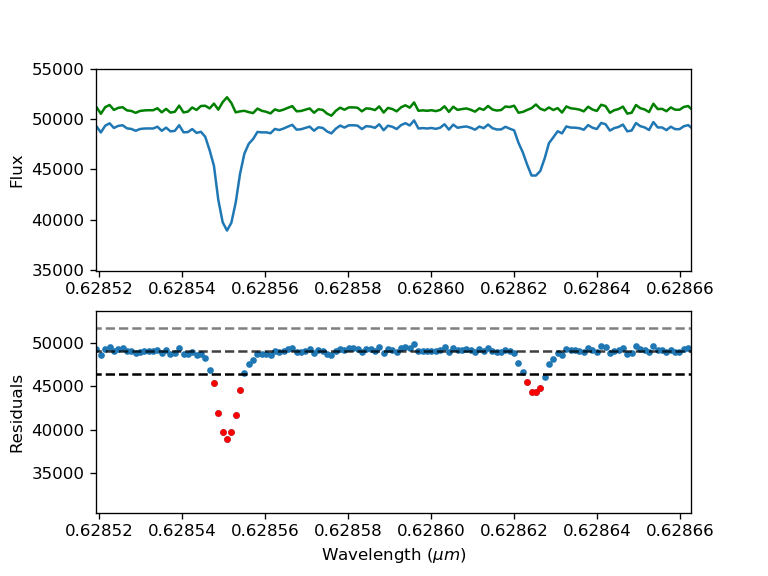

Text(0, 0.5, 'Residuals')

In [8]:
# Selecting the wavelength which have bad telluric correction
# for each order in the carmenes spectrum
# 
for wl_min, wl_max in zip(order_limits[::2], order_limits[1::2]):
    # Select telluric lines badly corrected
    idx_one_order, wl_bad_one_order = select_bad_tell_corr(wave, flux_in, trans, flux_corr,
                                                             wl_min, wl_max, mask_artefact, plot=True)
    if wl_min == order_limits[0]:
        idx_badly_corrected = idx_one_order
        wl_badly_corrected = wl_bad_one_order
    else:
        idx_badly_corrected = np.append(idx_badly_corrected, idx_one_order)
        wl_badly_corrected = np.append(wl_badly_corrected, wl_bad_one_order)
if espresso:
    pass
elif carmenes:
    plt.axvspan(0.9996668, 1.100366, alpha=0.1)
    plt.axvspan(1.16961, 1.330443, alpha=0.1)
    plt.axvspan(1.4995, 1.750583, alpha=0.1)
plt.xlabel('Wavelength ($\mu m$)')
plt.ylabel('Residuals')

In [ ]:
wl_badly_corrected
# Find indexes of wl_badly_corrected in the full wavelengths
idx_bad_values_wave= np.isin(wave, wl_badly_corrected)
print('Number of pixels with badly corrected telluric lines')
print(np.sum(idx_bad_values_wave))
print(idx_bad_values_wave.shape)
print(wave.shape)

In [ ]:
# Write the transmission file
with open('mtrans_carmenes.txt', 'w') as f:
    for wl, fl in zip(wave, trans):
        f.write("{} {}\n".format(wl,fl))

In [ ]:
# Computing RV precision and Quality
# for all orders, bands Y J and K
# --
# Changing the atmospheric model from TAPAS to Molecfit
eniric.atmmodel["base"] = 'mtrans_car-20160325T05h28m38s'
# Defining the bands
bands = ["Y", "J", "H"]
Y_mask = (wave > 0.9996668) & (wave < 1.100366)
J_mask = (wave > 1.16961 ) & (wave < 1.330443)
H_mask = (wave > 1.4995) &  (wave < 1.750583)
band_masks = [Y_mask, J_mask, H_mask]
qs_bands = []
plt.figure()
# Loop over the bands
for band, b_mask in zip(bands, band_masks):
    print('\nBand', band, '\n-------')
    print('RV precision')
    # Removing zeros flux points and artefacts
    mask = b_mask & (flux_corr > 0.) & ~mask_artefact & ~idx_bad_values_wave
    atm = Atmosphere.from_band(band, bary=False)
    # Obtain closest telluric model values at the wavelength values (telluric mask is super sampled).
    atm = atm.at(wave[mask])
    # Mask the transmission below given depth. e.g. 2%-5%
    atm.mask_transmission(2.0)
    
    # Masking the telluric lines
    rv_mask_tell = rv_precision(wave[mask], flux_in[mask], mask=atm.mask)
    # Corrected tellurics with Molecfit not weighted by the transmission
    rv_corr_tell = rv_precision(wave[mask], flux_corr[mask])
    print('input flux, atm mask: ', rv_mask_tell, ' > masking the tellurics'
      '\ncorr flux, trans mask:', rv_corr_tell, ' > telluric correction')
    if rv_corr_tell < rv_mask_tell:
        print(cl.green('> RV precision is improved'))
    else:
        print(cl.red('> RV precision is worsen'))
    
    print('\nQuality')
    q_mask_tell = quality(wave[mask], flux_in[mask], mask=atm.mask)
    q_corr_tell = quality(wave[mask], flux_corr[mask])
    print('input flux, atm mask: ', q_mask_tell, 
          '\ncorr flux, trans mask:', q_corr_tell)
    if q_corr_tell > q_mask_tell:
        print(cl.green('> Quality is improved'))
    else:
        print(cl.red('> Quality is worsen'))
        
    # Computing Quality factor in several intervals
    # needs fixing!!
    # saving all the values (q_mask, q_corr, q_wl) for each band Y, J and H
    qs = compute_Q_intervals(wave[mask], flux_in[mask], flux_corr[mask], band)
    qs_bands.append(qs)

    plt.plot(atm.wl, atm.mask, 'k-', alpha=0.2)
    plt.plot(wave[mask], flux_in[mask], 'C0-')
    plt.plot(wave[mask], trans[mask], 'C1-')
    plt.plot(wave[mask], flux_corr[mask], 'g.-')
    plt.plot(wave, mask, 'k.')


In [ ]:
# Plotting the Quality factor with telluric liens masked and corrected
# Reproducing the figure 2 of Artigau 2018 
# Qs_bands contains the bands H, J and K with: qs_mask, qs_corr, qs_wl

qs_bands[0].shape
print(qs_bands[0][0][0])
print(qs_bands[0][1][0])
print(qs_bands[0][2][0])

qs_values = qs_bands[0]
plt.figure()
ax1 = plt.subplot(211)
plt.semilogy(qs_bands[0][2], qs_bands[0][0], 'C1.')
plt.semilogy(qs_bands[1][2], qs_bands[1][0], 'C1.')
plt.semilogy(qs_bands[2][2], qs_bands[2][0], 'C1.', label='Telluric masked')

plt.semilogy(qs_bands[0][2], qs_bands[0][1], 'C0x')
plt.semilogy(qs_bands[1][2], qs_bands[1][1], 'C0x')
plt.semilogy(qs_bands[2][2], qs_bands[2][1], 'C0x', label='Telluric corrected')

plt.legend()
# plt.plot(wave[mask], atm.mask)
# plt.plot(wave[mask], flux_in[mask])
plt.axvspan(0.9996668, 1.100366, alpha=0.1)
plt.axvspan(1.16961, 1.330443, alpha=0.1)
plt.axvspan(1.4995, 1.750583, alpha=0.1)
plt.ylabel('Quality $_{0.2\%}$')

plt.subplot(212, sharex=ax1)
for i in range(3):
    res_quality = (qs_bands[i][1]-qs_bands[i][0])/qs_bands[i][1]
    plt.plot(qs_bands[i][2], res_quality, 'k.', alpha=0.7)
    plt.plot(qs_bands[i][2], qs_bands[i][2]*0.+np.mean(res_quality), 'r--')
    
plt.plot(1.0,1.1, 'r--', label='Average gain')
plt.xlabel('Wavelength ($\mu m$)')
plt.ylabel('(Q$_{corr}$ - Q$_{mask}$) / Q$_{corr}$')
plt.legend()

print(np.mean((qs_bands[0][1]-qs_bands[0][0])/qs_bands[0][1]*100.))
print(np.mean((qs_bands[1][1]-qs_bands[1][0])/qs_bands[1][1]*100.))
print(np.mean((qs_bands[2][1]-qs_bands[2][0])/qs_bands[2][1]*100.))

In [ ]:
# Problems / Future work
# 1. Need to differentiate between fully corrected lines and not fully corrected lines
# 1. Excluding not fully corrected telluric lines
# 2. The RV precision value is wrong because the spectra are not scaled to SNR 100 in J band

In [ ]:
# Reproducing the figure 2 of Artigau 2018 

In [ ]:
def compute_Q_intervals(wave, flux_in, flux_corr, band):
    """ 
    Computing the quality factor in several intervals 
    of ~2nm length in each Y, J, and H bands
    
    Reproduces the Figure 2 of Artigau 2018 in the Y, J and H bands
    --------------------------------------------------------------
    INPUTS: 
            wave = wavelength in a given band (Y, J, or H), arr
            flux_in = input flux in the same band, arr
            flux_corr = corrected flux in the same band, arr
            band = name of the band, str
    OUTPUTS: 
            qs_mask = quality factors when the tellurics are masked
            qs_corr = quality factors when the tellurics are corrected
            qs_wl = starting wl of the 2% interval
    """
    my_wl = wave[0]
    qs_mask = []
    qs_corr = []
    qs_wl = []
    while my_wl < wave[-1]:
        # Define wl interval of 2%
        delta_lambda = 0.002*my_wl
        # Mask the regions outside of the interval
        mask_2pc = (wave > my_wl) & (wave < (my_wl+delta_lambda))
        # print(my_wl, delta_lambda, wave[-1])
        
        # Check the wl interval is not falling between two orders
        if np.sum(mask_2pc) == 0:
            # Increment for the next interval
            my_wl = my_wl + delta_lambda
            print('Interval undefined > between 2 orders')
            continue
        else:
            # print('Nb of points in intervals: ', np.sum(mask_2pc), my_wl)
            pass
        
        # Load the atmospheric transmission of Molecfit
        atm = Atmosphere.from_band(band, bary=False)
        # Obtain closest telluric model values at the wavelength values
        atm = atm.at(wave[mask_2pc])
        # Mask the transmission below given depth. e.g. 2%-5%
        atm.mask_transmission(2.0)
        
        # Compute Q over the 2% interval
        q_mask_tell = quality(wave[mask_2pc], flux_in[mask_2pc], mask=atm.mask)
        q_corr_tell = quality(wave[mask_2pc], flux_corr[mask_2pc])
        
        # Save the Qs in two lists
        qs_mask.append(q_mask_tell)
        qs_corr.append(q_corr_tell)
        qs_wl.append(my_wl)
        
        # Increment for the next interval
        my_wl = my_wl + delta_lambda
    return np.array([qs_mask, qs_corr, qs_wl])

In [ ]:
# mask = (wave > 1.17) & (wave < 1.17574)
ind = trans[mask] > 0.97
fl = flux_in[mask]
tr = trans[mask]
ww = wave[mask]
res = fl - tr
# Residuals
avg_res = np.mean(res[ind])
print(avg_res)
max_res = avg_res + np.std(res[ind])
min_res = avg_res - np.std(res[ind])
res_10percent = avg_res*0.1

plt.subplot(212, sharex=ax1)
plt.plot(wave[mask], res, 'C0.')
plt.plot(ww[ind], res[ind], 'C1.')
plt.plot(ww[ind], ww[ind]*0. + max_res, 'k--')
plt.plot(ww[ind], ww[ind]*0. + min_res, 'r--')
plt.plot(ww[ind], ww[ind]*0 + (avg_res + abs(res_10percent)), 'k-')
plt.plot(ww[ind], ww[ind]*0 + (avg_res - abs(res_10percent)), 'r-')

In [ ]:
plt.figure()
wl_mask = Y_mask
# plt.plot(wave[mask], flux_in[mask])
plt.plot(wave, flux_in, 'k-', label='Input')
plt.plot(wave, flux_corr, 'g-', label='Corrected')
plt.plot(wave, data_tell['mtrans'], 'r-', label='Trans')
plt.axvspan(0.9996668, 1.100366, alpha=0.2)
plt.axvspan(1.16961, 1.330443, alpha=0.2)
plt.axvspan(1.4995, 1.750583, alpha=0.2)
# plt.legend()